# Projeto de Identificação de Pragas Agrícolas

## Introdução
Este projeto utiliza técnicas de aprendizado profundo para identificar pragas agrícolas a partir de imagens. Com o uso de um modelo pré-treinado (MobileNetV2) adaptado para o problema específico, o sistema classifica diferentes tipos de insetos, permitindo que agricultores identifiquem pragas de forma eficiente e tomem medidas preventivas ou corretivas para minimizar perdas na produção.

O projeto também incorpora técnicas de aumento de dados (data augmentation) para melhorar a robustez do modelo e oferece uma interface simples para exibição de resultados e teste de imagens.

## Objetivo
O objetivo principal deste projeto é:
- Fornecer uma ferramenta automatizada para classificação de pragas agrícolas.
- Auxiliar na detecção precoce de infestações.
- Reduzir o uso excessivo de pesticidas ao fornecer informações precisas sobre as pragas.

## Lista de Membros do Grupo
- **Lucas Giovani Campos Lopes Martins** - 10390126


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter


In [18]:
import zipfile

# Descompactar o arquivo zip
zip_path = '/content/imageminsetos.zip'  # Substitua pelo caminho correto
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/imageminsetos')

# Caminho base
base_dir = '/content/imageminsetos/imageminsetos'
print("Classes no conjunto de dados:", os.listdir(base_dir))


Classes no conjunto de dados: ['weevil', 'ants', 'catterpillar']


In [19]:
# Função para carregar todas as imagens e rótulos
def load_images_and_labels(generator):
    images, labels = [], []
    class_indices = generator.class_indices
    for class_name, class_idx in class_indices.items():
        class_path = os.path.join(base_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Carregar imagem e converter para array
                img = load_img(img_path, target_size=(224, 224))  # Aumentar a resolução para 224x224
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Erro ao carregar {img_path}: {e}")
    return np.array(images), np.array(labels)

# Carregar dados e rótulos
X, y = load_images_and_labels(
    ImageDataGenerator().flow_from_directory(base_dir)
)

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Distribuição inicial das classes: {Counter(y_train)}")


Found 1123 images belonging to 3 classes.
Distribuição inicial das classes: Counter({0: 320, 2: 315, 1: 263})


In [11]:
# Redimensionar para 1D
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_flat, y_train)

# Voltar ao formato original
X_resampled = X_resampled.reshape(-1, 224, 224, 3)

# Converter rótulos para categóricos
y_train_categorical = to_categorical(y_train)
y_resampled_categorical = to_categorical(y_resampled)

# Confirmar as novas distribuições de classes
print(f"Distribuição após o SMOTE: {Counter(y_resampled)}")


Distribuição após o SMOTE: Counter({2: 320, 0: 320, 1: 320})


In [12]:
train_dir = base_dir
img_size = (224, 224)  # Redimensionar imagens
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Separar parte para validação
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Dados de treinamento
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Dados de validação
)

Found 900 images belonging to 3 classes.
Found 223 images belonging to 3 classes.


In [13]:
# Carregar o modelo pré-treinado MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo pré-treinado
base_model.trainable = False

# Adicionar as camadas finais para classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout para regularização
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# Configurar callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Treinar o modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7495 - loss: 0.7520 - val_accuracy: 0.9462 - val_loss: 0.1306 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9451 - loss: 0.1569 - val_accuracy: 0.9327 - val_loss: 0.1709 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9462 - loss: 0.1156 - val_accuracy: 0.9776 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9593 - loss: 0.1334 - val_accuracy: 0.9552 - val_loss: 0.1333 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9804 - loss: 0.0606 - val_accuracy: 0.9776 - val_loss: 0.0727 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9715 - loss: 0.0835 - val_accuracy: 0.9507 - val_loss: 0.0884 - learning_rate: 0.0010
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9796 - loss: 0.0480 - val_accuracy: 0.9821 - va

In [15]:
# Avaliar o modelo
loss, accuracy = model.evaluate(validation_generator)
print(f"Acurácia no conjunto de validação: {accuracy:.2f}")
print(f"Loss no conjunto de validação: {loss:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9412 - loss: 0.1563
Acurácia no conjunto de validação: 0.95
Loss no conjunto de validação: 0.13


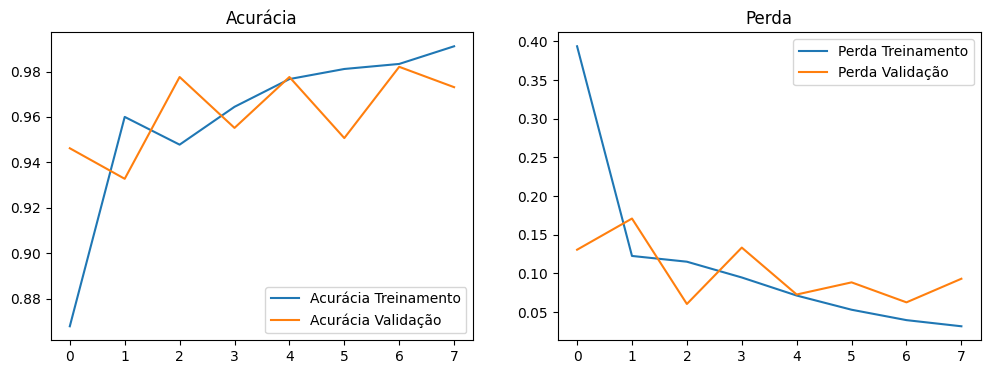

In [16]:
# Avaliar o modelo
# Plotar os gráficos de perda e acurácia
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.legend()
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.legend()
plt.title('Perda')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


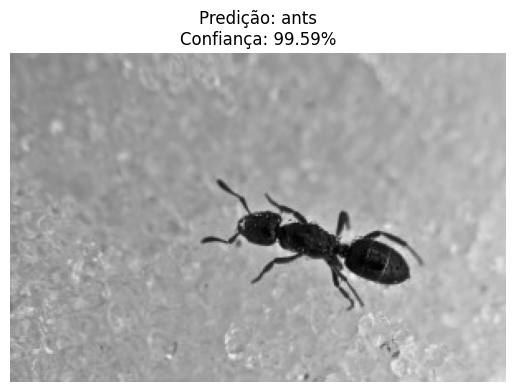

Informações adicionais:
- Caminho da imagem: /content/imageminsetos/imageminsetos/ants/ants (320).jpg
- Classe prevista: ants
- Confiança na predição: 99.59%
- Probabilidades para cada classe:
  ants: 99.59%
  catterpillar: 0.03%
  weevil: 0.39%


In [30]:
# Função para exibir imagem e previsão
def display_prediction(image_path):
  img = load_img(image_path, target_size=img_size)
  img_array = img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão do batch

  # Fazer a previsão
  prediction = model.predict(img_array)
  class_indices = train_generator.class_indices
  class_names = list(class_indices.keys())
  predicted_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction) * 100

  # Exibir a imagem e os resultados
  plt.imshow(load_img(image_path))
  plt.axis('off')
  plt.title(f"Predição: {predicted_class}\nConfiança: {confidence:.2f}%")
  plt.show()

  print("Informações adicionais:")
  print(f"- Caminho da imagem: {image_path}")
  print(f"- Classe prevista: {predicted_class}")
  print(f"- Confiança na predição: {confidence:.2f}%")
  print(f"- Probabilidades para cada classe:")
  for idx, class_name in enumerate(class_names):
      print(f"  {class_name}: {prediction[0][idx] * 100:.2f}%")

# Testar com uma imagem do conjunto
test_image_path = '/content/imageminsetos/imageminsetos/ants/ants (320).jpg'
display_prediction(test_image_path)



--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


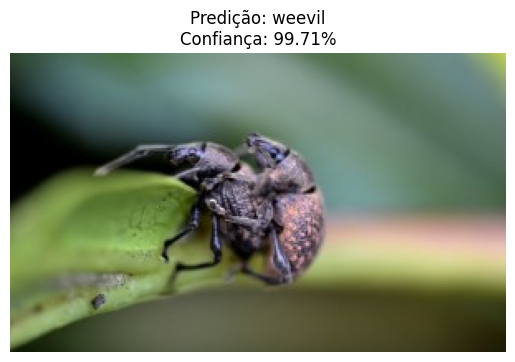

Informações adicionais:
- Caminho da imagem: /content/imageminsetos/imageminsetos/weevil/Weevil (233).jpg
- Classe prevista: weevil
- Confiança na predição: 99.71%
- Probabilidades para cada classe:
  ants: 0.06%
  catterpillar: 0.23%
  weevil: 99.71%

--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


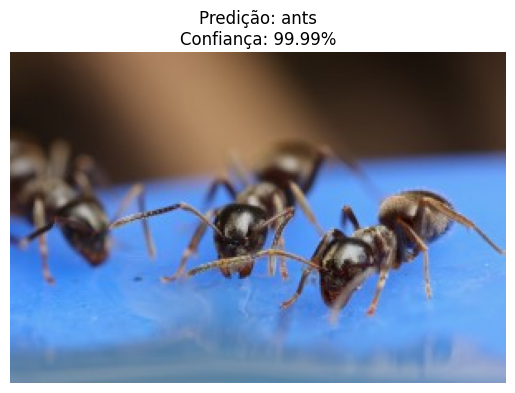

Informações adicionais:
- Caminho da imagem: /content/imageminsetos/imageminsetos/ants/ants (79).jpg
- Classe prevista: ants
- Confiança na predição: 99.99%
- Probabilidades para cada classe:
  ants: 99.99%
  catterpillar: 0.01%
  weevil: 0.00%

--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


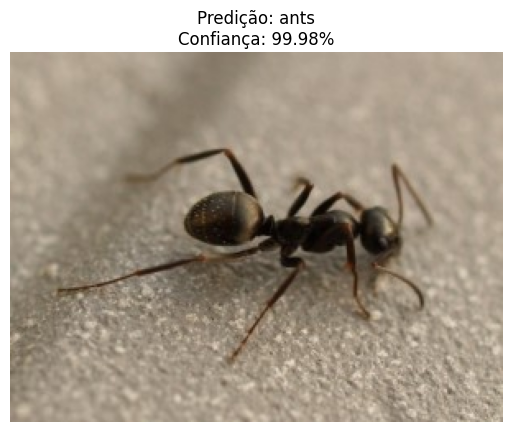

Informações adicionais:
- Caminho da imagem: /content/imageminsetos/imageminsetos/ants/ants (63).jpg
- Classe prevista: ants
- Confiança na predição: 99.98%
- Probabilidades para cada classe:
  ants: 99.98%
  catterpillar: 0.01%
  weevil: 0.00%


In [36]:
import random

# Função para testar imagens aleatórias de uma pasta
def test_random_images(num_images=3):
    # Listar todas as subpastas e arquivos no conjunto de dados
    all_classes = os.listdir(base_dir)
    for _ in range(num_images):
        # Escolher uma classe aleatória
        random_class = random.choice(all_classes)
        class_path = os.path.join(base_dir, random_class)

        # Escolher uma imagem aleatória dessa classe
        random_image = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, random_image)

        # Exibir a previsão para essa imagem
        print("\n" + "-"*50)
        display_prediction(image_path)

# Testar 3 imagens aleatórias
test_random_images(3)
